# Online Retailer Customer Segmentation
## Data Fellowship IYKRA Batch 5
### Abednego Kristanto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mpl_toolkits.mplot3d import Axes3D 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

### 1. Business Understanding
Customer segmentation is the problem of uncovering information about a firm's customer base, based on their interactions with the business. In most cases this interaction is in terms of their purchase behavior and patterns. The dataset is taken from the following source:
https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis

Because the data only include the interaction between the customers and the online retailer, there will only 3 features for clustering which are how many items in total each customer bought or sum of quantity, how much money each customer spent or total paid, and how often each customer bought items or frequency. From the result of customer segmentation, relevant promotion or member card could be offered to the right customers, and hopefully will improve their loyalty to the retailer.

### 2. Data Understanding and Preparation

In [2]:
# load dataset
df_ini = pd.read_excel('Online Retail.xlsx')
df_ini.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### a) Exploratory Data Analysis and Data Cleansing

In [3]:
# check dataset shape
df = df_ini
df.shape

(541909, 8)

In [4]:
# check dataset types
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [5]:
# check null value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# drop customer ID with null value
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
# remove duplicate value
df = df.drop_duplicates()
df.shape

(401604, 8)

In [8]:
# describe numerical data
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# filter out return transaction / rows with negative quantity
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [10]:
#Check data shape
df.shape

(392692, 8)

In [11]:
# check how many rows with max quantity
df[df['Quantity']==df['Quantity'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [12]:
# check how many rows with max unit price
df[df['UnitPrice']==df['UnitPrice'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom


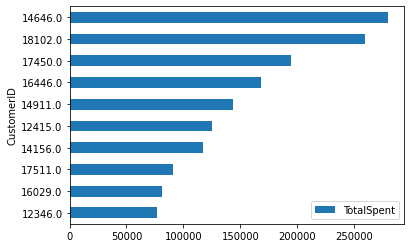

In [13]:
# Top 10 Customer based on total money spent
cust_df = df
cust_df['TotalSpent'] = cust_df['Quantity'] * cust_df['UnitPrice']
cust_df = cust_df.groupby(['CustomerID']).sum().sort_values(by='TotalSpent',ascending=False).head(10)
ax = cust_df.plot.barh(y='TotalSpent')
ax.invert_yaxis()

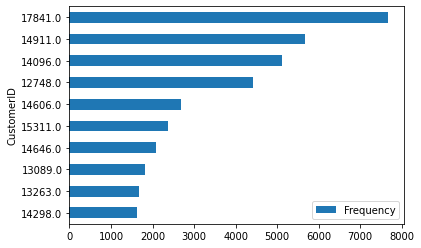

In [14]:
# top 10 loyal customers based on buying frequency
freq_df = df
freq_df['Frequency'] = 1
freq_df = freq_df.groupby(['CustomerID']).sum().sort_values(by='Frequency',ascending=False).head(10)
ax = freq_df.plot.barh(y='Frequency')
ax.invert_yaxis()

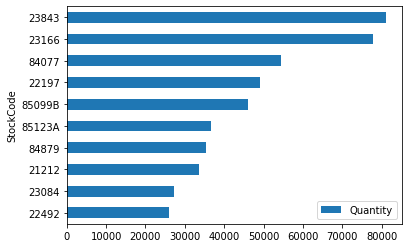

In [15]:
# Top 10 best selling product based on quantity sold
prod_df = df.groupby(['StockCode']).sum().sort_values(by='Quantity',ascending=False).head(10)
ax = prod_df.plot.barh(y='Quantity')
ax.invert_yaxis()

In [16]:
# What is top 3 best selling product description?
print(df[df['StockCode']==23843].loc[540421,:].Description)
print(df[df['StockCode']==23166].loc[61619,:].Description)
print(df[df['StockCode']==84077].loc[3259,:].Description)

PAPER CRAFT , LITTLE BIRDIE
MEDIUM CERAMIC TOP STORAGE JAR
WORLD WAR 2 GLIDERS ASSTD DESIGNS


#### b) Clustering Feature Selection
For Customer segmentation we use 3 feature which are: Total money spent by the customers, Quantity of items bought by customer, and frequency of customers bought items from online retail.

In [17]:
# adding total money spent column to be calculated at grouping
df['TotalSpent'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpent,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1


In [18]:
# adding frequency column to be calculated at grouping
df['Frequency'] = 1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpent,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1


In [19]:
# group by customerID and sum all numerical value
clust_df = df.groupby(['CustomerID']).sum()
clust_df.head()

,Quantity,UnitPrice,TotalSpent,Frequency
CustomerID,,,,
12346.0,74215,1.04,77183.60,1
12347.0,2458,481.21,4310.00,182
12348.0,2341,178.71,1797.24,31
12349.0,631,605.10,1757.55,73
12350.0,197,65.30,334.40,17


In [20]:
# drop unit price per item column
clust_df = clust_df.drop(['UnitPrice'], axis=1)
clust_df.head()

,Quantity,TotalSpent,Frequency
CustomerID,,,
12346.0,74215,77183.60,1
12347.0,2458,4310.00,182
12348.0,2341,1797.24,31
12349.0,631,1757.55,73
12350.0,197,334.40,17


In [21]:
clust_df.describe()

,Quantity,TotalSpent,Frequency
count,4338.000000,4338.000000,4338.000000
mean,1187.644537,2048.688081,90.523744
std,5043.619654,8985.230220,225.506968
min,1.000000,3.750000,1.000000
25%,159.000000,306.482500,17.000000
50%,378.000000,668.570000,41.000000
75%,989.750000,1660.597500,98.000000
max,196915.000000,280206.020000,7676.000000


#### c) Correlation Between Variables

            Quantity  TotalSpent  Frequency
Quantity    1.000000    0.922942   0.433156
TotalSpent  0.922942    1.000000   0.425282
Frequency   0.433156    0.425282   1.000000


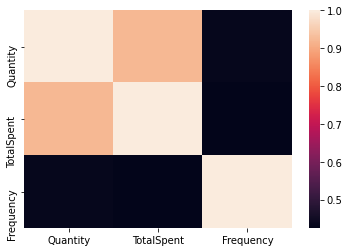

In [22]:
# features correlation heatmap
print(clust_df[['Quantity','TotalSpent','Frequency']].corr())
sns.heatmap(clust_df[['Quantity','TotalSpent','Frequency']].corr());

### 3. Modelling
#### a) Further Features Preprocessing

<AxesSubplot:xlabel='Quantity'>

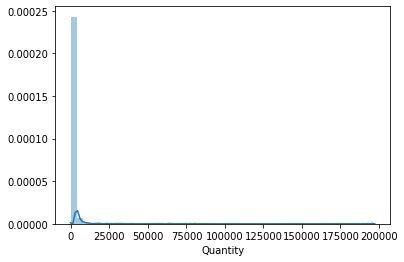

In [23]:
# Distribution of Quantity feature
sns.distplot(clust_df['Quantity'])

<AxesSubplot:xlabel='TotalSpent'>

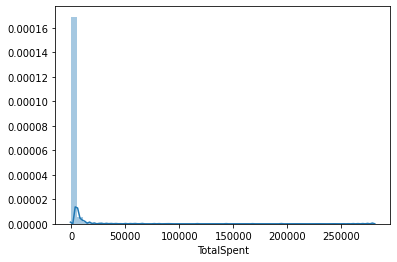

In [24]:
# Distribution of TotalPaid feature
sns.distplot(clust_df['TotalSpent'])

<AxesSubplot:xlabel='Frequency'>

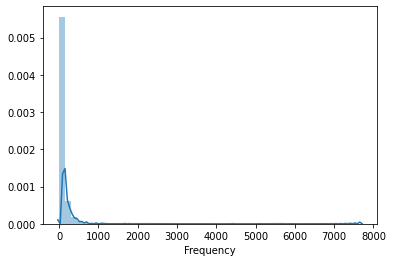

In [25]:
# Distribution of frequency feature
sns.distplot(clust_df['Frequency'])

From the distribution plots above, all of the features are heavily right skewed. Therefore, to build a good clustering model, further preprocessing is needed before dataset could be fitted in clustering model. First, all the values in all features have to be converted to its logarithmic value.

In [26]:
# features pre-procesing (convert to logarithmic value)
clust_df['log_Quantity'] = clust_df['Quantity'].apply(np.log)
clust_df['log_TotalSpent'] = clust_df['TotalSpent'].apply(np.log)
clust_df['log_Frequency'] = clust_df['Frequency'].apply(np.log)
clust_df.head()

,Quantity,TotalSpent,Frequency,log_Quantity,log_TotalSpent,log_Frequency
CustomerID,,,,,,
12346.0,74215,77183.60,1,11.214722,11.253942,0.000000
12347.0,2458,4310.00,182,7.807103,8.368693,5.204007
12348.0,2341,1797.24,31,7.758333,7.494007,3.433987
12349.0,631,1757.55,73,6.447306,7.471676,4.290459
12350.0,197,334.40,17,5.283204,5.812338,2.833213


In [27]:
clust_df.describe()

,Quantity,TotalSpent,Frequency,log_Quantity,log_TotalSpent,log_Frequency
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,1187.644537,2048.688081,90.523744,5.973465,6.585704,3.671522
std,5043.619654,8985.230220,225.506968,1.384769,1.261763,1.320854
min,1.000000,3.750000,1.000000,0.000000,1.321756,0.000000
25%,159.000000,306.482500,17.000000,5.068904,5.725161,2.833213
50%,378.000000,668.570000,41.000000,5.934894,6.505141,3.713572
75%,989.750000,1660.597500,98.000000,6.897452,7.414933,4.584967
max,196915.000000,280206.020000,7676.000000,12.190527,12.543280,8.945854


In [28]:
# features pre-procesing (standardized log value)
X = clust_df[['log_Quantity','log_TotalSpent','log_Frequency']]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

clust_df['ls_Quantity'] = X_scaled[:,0]
clust_df['ls_TotalSpent'] = X_scaled[:,1]
clust_df['ls_Frequency'] = X_scaled[:,2]
clust_df.head()

,Quantity,TotalSpent,Frequency,log_Quantity,log_TotalSpent,log_Frequency,ls_Quantity,ls_TotalSpent,ls_Frequency
CustomerID,,,,,,,,,
12346.0,74215,77183.60,1,11.214722,11.253942,0.000000,3.785370,3.700201,-2.779978
12347.0,2458,4310.00,182,7.807103,8.368693,5.204007,1.324301,1.413256,1.160356
12348.0,2341,1797.24,31,7.758333,7.494007,3.433987,1.289078,0.719951,-0.179855
12349.0,631,1757.55,73,6.447306,7.471676,4.290459,0.342220,0.702251,0.468643
12350.0,197,334.40,17,5.283204,5.812338,2.833213,-0.498524,-0.612996,-0.634745


In [29]:
clust_df.describe()

,Quantity,TotalSpent,Frequency,log_Quantity,log_TotalSpent,log_Frequency,ls_Quantity,ls_TotalSpent,ls_Frequency
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4.338000e+03,4.338000e+03,4.338000e+03
mean,1187.644537,2048.688081,90.523744,5.973465,6.585704,3.671522,-2.145203e-16,1.559636e-16,1.699245e-16
std,5043.619654,8985.230220,225.506968,1.384769,1.261763,1.320854,1.000115e+00,1.000115e+00,1.000115e+00
min,1.000000,3.750000,1.000000,0.000000,1.321756,0.000000,-4.314189e+00,-4.172381e+00,-2.779978e+00
25%,159.000000,306.482500,17.000000,5.068904,5.725161,2.833213,-6.532967e-01,-6.820955e-01,-6.347448e-01
50%,378.000000,668.570000,41.000000,5.934894,6.505141,3.713572,-2.785665e-02,-6.385708e-02,3.183903e-02
75%,989.750000,1660.597500,98.000000,6.897452,7.414933,4.584967,6.673274e-01,6.572740e-01,6.916361e-01
max,196915.000000,280206.020000,7676.000000,12.190527,12.543280,8.945854,4.490121e+00,4.722173e+00,3.993582e+00


#### b) K-Means Clustering Modelling

In [30]:
# build clustering model
model_df = clust_df[['ls_Quantity','ls_TotalSpent','ls_Frequency']]

clust_model = KMeans(n_clusters = 2, init='k-means++',n_init=10,
                     max_iter=300,tol=1e-04,random_state=42)
clust_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [31]:
# fitting dataset into clustering model
clust_model = clust_model.fit(model_df)

In [32]:
# get label of each users
label = clust_model.labels_
label[:5]

array([1, 1, 1, 1, 0])

In [33]:
# get cluster centers
cluster_center = clust_model.cluster_centers_
cluster_center

array([[-0.71838308, -0.73648068, -0.68140483],
       [ 0.78564482,  0.80543689,  0.74520432]])

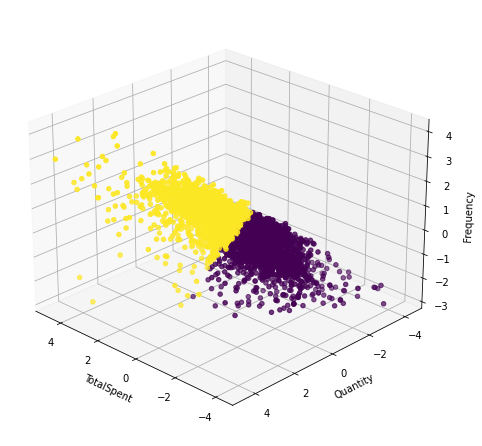

In [34]:
# plot 3D scatter plot with label color code
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=134)

plt.cla()
ax.set_xlabel('TotalSpent')
ax.set_ylabel('Quantity')
ax.set_zlabel('Frequency')

ax.scatter(model_df['ls_TotalSpent'], model_df['ls_Quantity'],
           model_df['ls_Frequency'], c= label.astype(np.float))

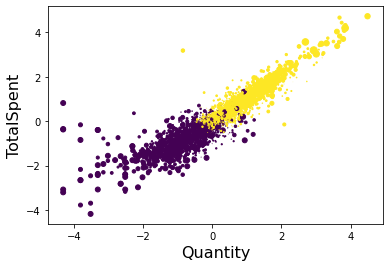

In [35]:
# plot totalspent vs quantity 2D plot
area = np.pi * (model_df['ls_Frequency'])**2  
plt.scatter(model_df['ls_Quantity'], model_df['ls_TotalSpent'],
            s=area, c=label.astype(np.float))
plt.xlabel('Quantity', fontsize=16)
plt.ylabel('TotalSpent', fontsize=16)

plt.show()

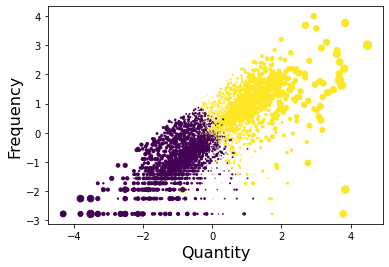

In [36]:
# plot frequency vs quantity 2D plot
area = np.pi * (model_df['ls_TotalSpent'])**2  
plt.scatter(model_df['ls_Quantity'], model_df['ls_Frequency'],
            s=area, c=label.astype(np.float))
plt.xlabel('Quantity', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()

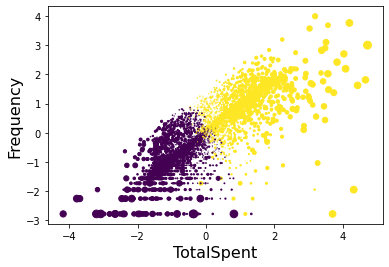

In [37]:
# plot frequency vs totalspent 2D plot
area = np.pi * (model_df['ls_Quantity'])**2  
plt.scatter(model_df['ls_TotalSpent'], model_df['ls_Frequency'],
            s=area, c=label.astype(np.float))
plt.xlabel('TotalSpent', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()

### 4. Evaluation

In [38]:
# Davies-Bouldin score
DB_score = metrics.davies_bouldin_score
print("DB score =", DB_score(model_df,label))

DB score = 0.749416595845803


C:\Users\ABEDNEGO\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


DB index of this model is 0.75. It is still very high for clustering model. Looking at the distribution of data, better clustering algorithm is needed to achieve better performance. In addition, more customer features is also helpful in order to have better customer segmentation.